In [1]:
from helpers.vae import VAE
from helpers.train import train_online, train

In [2]:
from helpers.train import train_online_alternately

In [3]:
from helpers.convert_to_var_foo import convert_to_var

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

### Создание данных

In [7]:
dim = 50
num_classes = 10

In [8]:
def get_one_hot_object(obj_class, dim, num_classes):
    x = np.zeros(dim)
    x[:(dim//num_classes) * (obj_class+1)] = 1
    return x

In [9]:
X_train = []
X_test = []
num_per_class = 250
for i in range(num_classes):
    X_test.append(get_one_hot_object(i, dim, num_classes))
    for j in range(num_per_class):
        X_train.append(get_one_hot_object(i,
                                          dim, num_classes))
X_train = np.array(X_train)
X_test = np.array(X_test)

In [151]:
schedule = np.load('../trajectory_big.npy')
schedule = schedule[:1000]

In [152]:
num_classes = len(np.unique(schedule))

In [153]:
num_classes

16

In [154]:
_, red_lines, _ = np.unique(schedule, return_counts=True, return_index=True)

#### Посмотрим, как ведут себя KL и итоговый функционал, когда PG<0.

0.055
CPU times: user 2min 6s, sys: 508 ms, total: 2min 7s
Wall time: 52.6 s


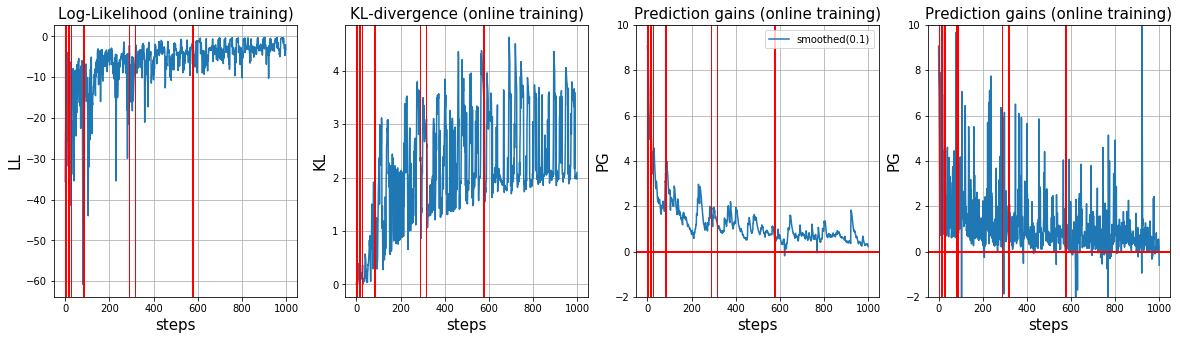

In [156]:
%%time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


model = VAE(input_shape=(-1, dim), n_samples=100)
optimizer = optim.RMSprop(model.parameters(), lr=1e-4, momentum=0)
results = train_online(schedule, X_test,model, optimizer, kl_weight=1, alpha=0.1,
                       red_lines=red_lines, img_name=None)
mean_last_ll, pct, all_log_probs, pgs, total_loss_gains, kl_gains = results
print(pct)

In [157]:
from collections import defaultdict
n = len(pgs)
cnt = defaultdict(int)

for i in range(n):
    pg_sign = 1 if pgs[i]>=0 else -1
    loss_sign = 1 if total_loss_gains[i]>=0 else -1
    kl_sign = 1 if kl_gains[i] >= 0 else -1
    
    cnt[(pg_sign, loss_sign, kl_sign)] += 1

In [20]:
# Loss = -1*LL + KLD

#(-1,-1,-1) - LL уменьш, Loss уменьш, KL уменьш => -1*LL увел меньше, чем KL уменьш - ОК - НОРМА ДЛЯ МОДЕЛИ(159).
#(-1,-1,1) - LL уменьш, Loss уменьш, KL увел => -1*LL увел, KL увел - не ОК -------------------------------.

#(-1,1,-1) - LL уменьш, Loss увел, KL уменьш => -1*LL увел, KL уменьш - ОК -  НОРМА ДЛЯ МОДЕЛИ (135).
#(-1,1, 1) - LL уменьш, Loss увел, KL увел => -1*LL увел, KL увел - ОК НЕ НОРМА ДЛЯ МОДЕЛИ (28).

#(1,-1,-1) - LL увел, Loss уменьш, KL уменьш - ОК (260)
#(1,-1,1) -  LL увел, Loss уменьш, KL увел - ОК (388)

#(1,1,-1) - LL увел, Loss увел, KL уменьш - не ОК------------
#(1,1,1) - LL увел, Loss увел, KL увел - ОК (30)

In [158]:
num_steps = len(pgs)

In [159]:
total_neg_pct = (cnt[(-1,1,1)]+cnt[(-1,1,-1)]+cnt[(-1,-1,-1)])/num_steps
good_neg_pct = (cnt[(-1,-1,-1)] + cnt[(-1, 1, -1)])/num_steps
bad_neg_pct = cnt[(-1,1,1)]/num_steps

In [160]:
print(total_neg_pct, good_neg_pct,  bad_neg_pct)

0.055 0.048 0.007


## Счетчики

In [161]:
from helpers.plots import plot_smoothed_pgs, plot_pseudo_counters_with_alpha_and_degree, plot_counters
from helpers.get_pseudo_counters import get_counters, get_pseudo_count

In [162]:
def smooth(arr, alpha):
    smothed = []
    for i, x in enumerate(arr):
        if i == 0:
            smothed.append(x)
        else:
            smothed.append((1-alpha)*smothed[-1] + alpha*x)
    return np.array(smothed)

#### Зависимость Pseudo-Count on PG

(0, 10)

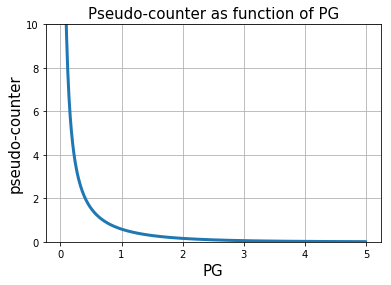

In [163]:
pg_arange = np.arange(0.01, 5, 0.01)
pseudo_cnt = [get_pseudo_count(i) for i in pg_arange]

plt.plot(pg_arange, pseudo_cnt, linewidth=3)
plt.grid()
plt.xlabel('PG', fontsize=15)
plt.ylabel('pseudo-counter', fontsize=15)
plt.title('Pseudo-counter as function of PG', fontsize=15)
plt.ylim((0,10))

#### Pseudo-counter для PG_n = 1/n

Text(0.5,1,'Pseudo-counters for PG_n=1/n')

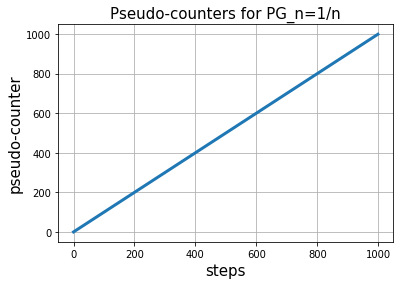

In [29]:
pg_arange = 1 / (1+np.arange(1000))
pseudo_cnt = [get_pseudo_count(i) for i in pg_arange]

plt.plot(pseudo_cnt, linewidth=3)
plt.grid()
plt.ylabel('pseudo-counter', fontsize=15)
plt.xlabel('steps', fontsize=15)
plt.title('Pseudo-counters for PG_n=1/n', fontsize=15)

In [64]:
def get_der(arr):
    der = []
    for i in range(len(arr)-1):
        der.append(arr[i+1]-arr[i])
    return der

In [166]:
def plot_smoothed_pgs(pgs, alpha=0.1, img_name=None):
    pgs = smooth(pgs, alpha)
    
    degree_range = [0, 0.5, 1]
    degree_names = ['PG_n', 'PG_n/sqrt(n)',  'PG_n/n']

    plt.figure(figsize=(25, 7*len(degree_range)))
    n = len(degree_range)
    m = 3
    num_points = len(pgs)
    arange = np.arange(num_points)+1
    pattern = 1 / (np.arange(num_points) + 1)
    
    fontsize = 20
    
    for i, degree in enumerate(degree_range):
        plt.subplot(n, 3, i*m+1)
        
        c,d = np.polyfit(1/arange, pgs/arange**degree, deg=1)
        
        #plt.plot(pattern, label='1/n', linewidth=4)
        plt.plot(pgs / arange**degree, label=degree_names[i], linewidth=4)
        plt.plot(arange, c/arange+d, label='fit c/n+d, c={:.2f}, d={:.2f}'.format(c,d), linewidth=4)
        plt.xlabel('steps', fontsize=fontsize)
        plt.ylabel('PG', fontsize=fontsize)
        plt.grid()
        plt.title("PG and 1/n", fontsize=fontsize)
        plt.legend(loc='upper right', fontsize=fontsize)
        plt.ylim(0,5)
        ##########################################
        plt.subplot(n, 3, i*m+2)
        plt.plot((pgs / arange**degree) / pattern, label=degree_names[i]+' over (1/n)', linewidth=4)
        plt.xlabel('steps', fontsize=fontsize)
        plt.ylabel('PG', fontsize=fontsize)
        plt.grid()
        plt.title("PG / (1/n)", fontsize=fontsize)
        plt.legend(loc='upper right', fontsize=fontsize)
        ##########################################
        plt.subplot(n, 3, i*m+3)
        plt.plot(get_der(pattern), label='increments of 1/n', linewidth=4)
        plt.plot(get_der(pgs/arange**degree), label='increments of '+degree_names[i], linewidth=4)
        plt.xlabel('steps', fontsize=fontsize)
        plt.ylabel('increments', fontsize=fontsize)
        plt.title('Increments', fontsize=fontsize)
        plt.legend(loc='upper right', fontsize=fontsize)
        plt.ylim(-5,5)
        plt.grid()

    if img_name is not None:
        plt.savefig(img_name)
        plt.close()

## w_KL=1e-2

0.02
CPU times: user 2min 7s, sys: 548 ms, total: 2min 8s
Wall time: 53.2 s


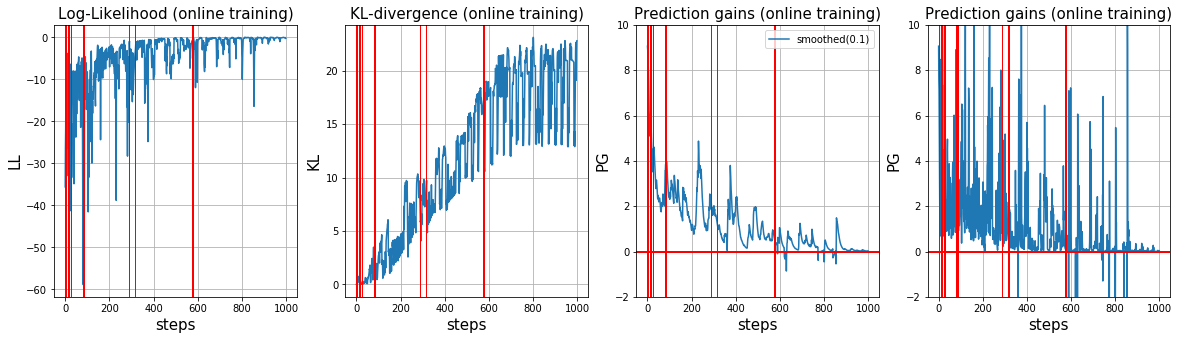

In [165]:
%%time
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

model = VAE(input_shape=(-1, dim), n_samples=100)
optimizer = optim.RMSprop(model.parameters(), lr=1e-4, momentum=0)
results = train_online(schedule, X_test,model, optimizer, kl_weight=1e-2, red_lines=red_lines)
mean_last_ll, pct, all_log_probs, pgs, total_loss_gains, kl_gains = results
print(pct)

In [135]:
real_counters, pseudo_counters, pgs_by_classes = get_counters(schedule, pgs, num_classes)

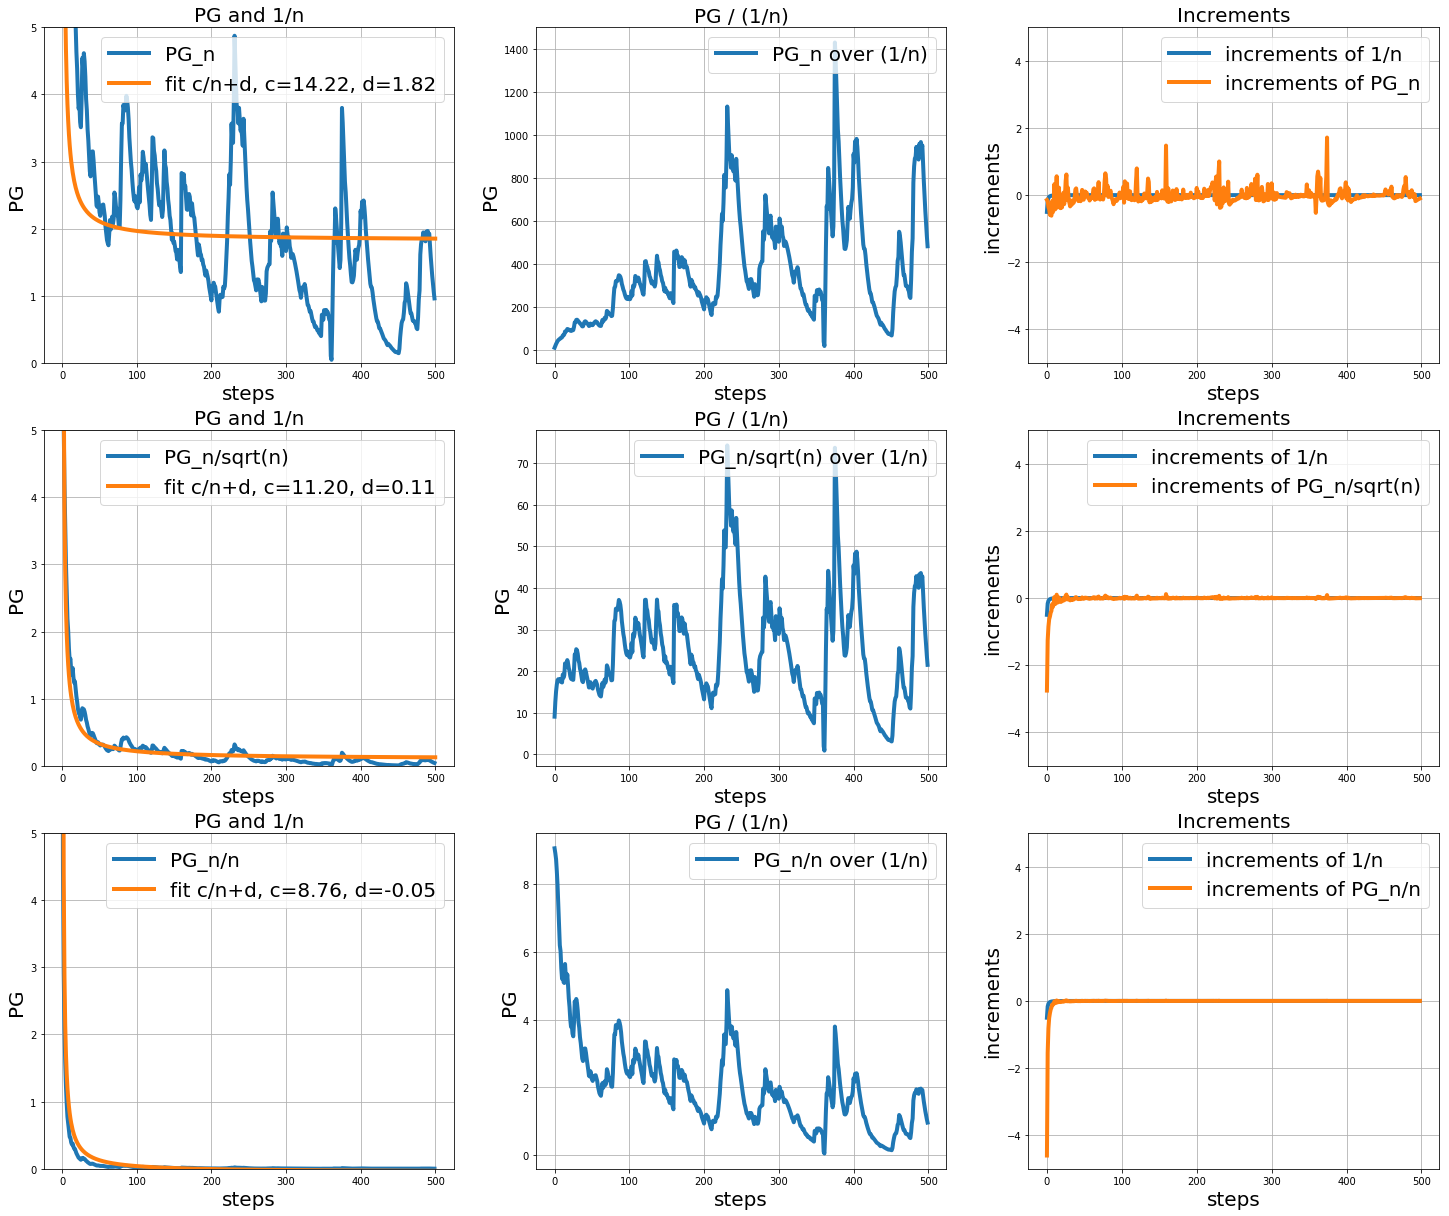

In [137]:
plot_smoothed_pgs(pgs)

In [ ]:
# рисовать не на одном графике, а графики вида f_1/f_2

In [184]:
def plot_pseudo_counters_with_alpha_and_degree(pgs, schedule, num_classes,
                                               classes_to_plot=None,
                                               alpha_range=[0.01, 0.1, 0.25],
                                               degree_range=[0, 0.5, 1],
                                               img_name=None,
                                               ):
    if classes_to_plot is None:
        classes_to_plot = np.arange(num_classes)
        
    n = len(alpha_range)
    plt.figure(figsize=(7 * n, 7 * len(classes_to_plot)))

    real_counters, _, _ = get_counters(schedule, pgs, num_classes)
    for i_cl, cl in enumerate(classes_to_plot):
        for i, alpha in enumerate(alpha_range):

            plt.subplot(len(classes_to_plot), n, i_cl*n+i+1)
            plt.plot(real_counters[cl], label='real_counters', linewidth=4)

            for j, degree in enumerate(degree_range):
                smoothed_pgs = smooth(pgs, alpha) / (np.arange(len(pgs)) + 1) ** degree
                _, pseudo_counters, _ = get_counters(schedule, smoothed_pgs, num_classes)
                plt.plot(pseudo_counters[cl], label='degree={}'.format(degree))
                plt.grid()
                plt.xlabel('steps', fontsize=15)
                plt.ylabel('counters: class {}'.format(cl+1), fontsize=15)
                plt.title('Pseudo counters, alpha={}'.format(alpha), fontsize=15)
                plt.legend(loc='upper right', fontsize=15)
                plt.ylim(0, 2 * real_counters.max())
    if img_name is not None:
        plt.savefig(img_name)
        plt.close()

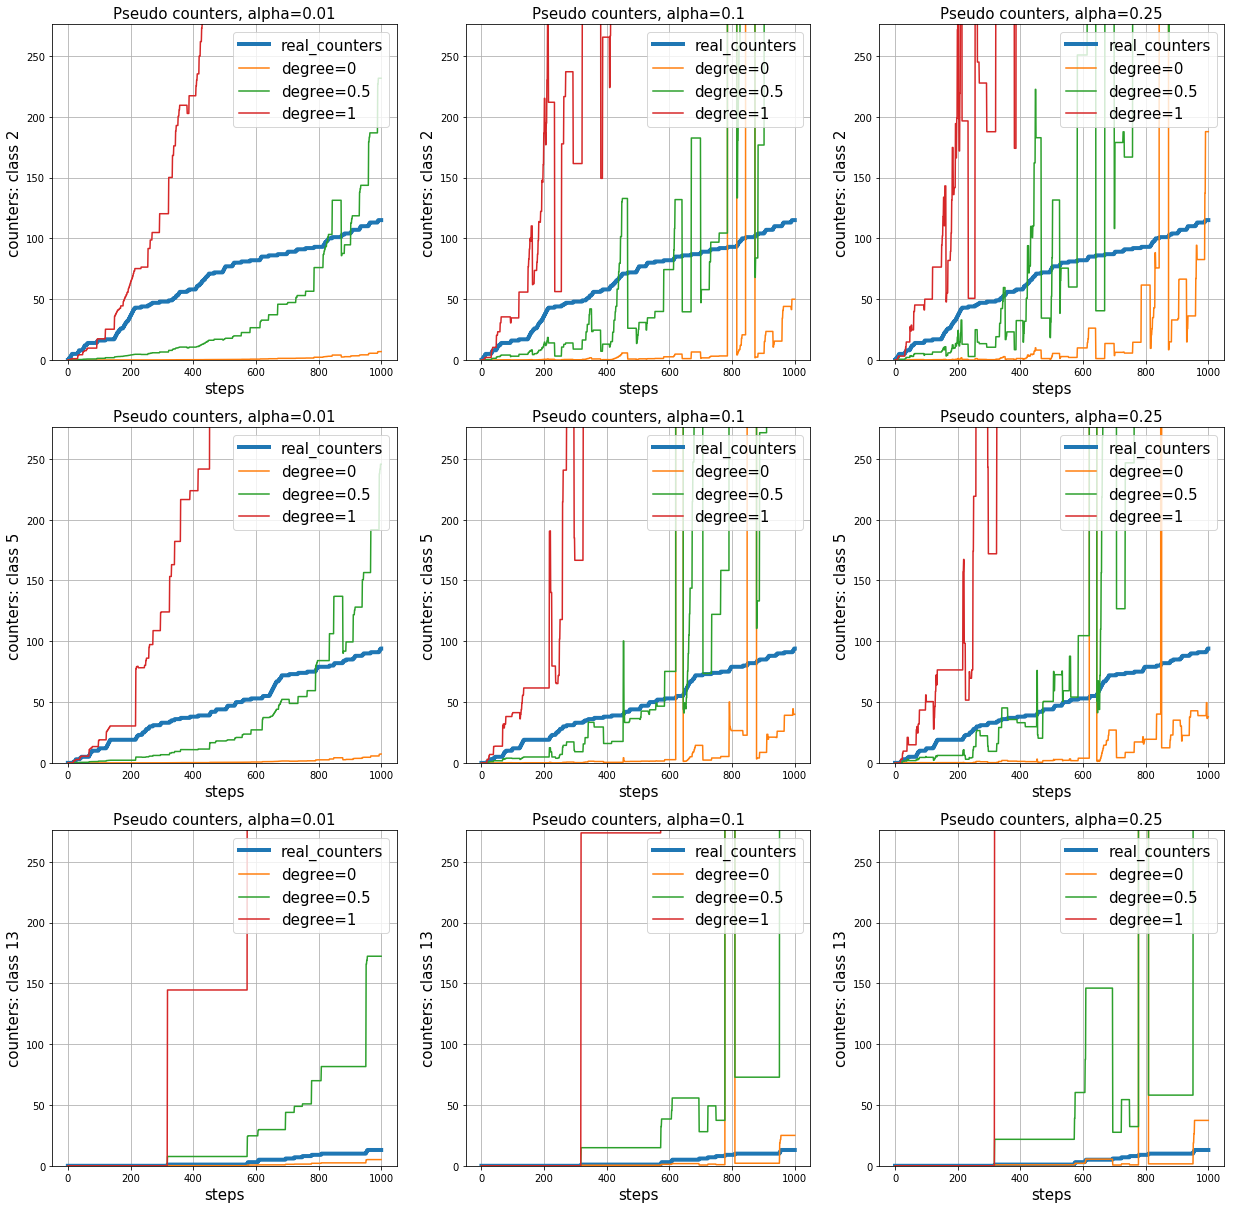

In [186]:
plot_pseudo_counters_with_alpha_and_degree(pgs, schedule, num_classes,
                                           classes_to_plot=[1, 4, 12],
                                           alpha_range=[0.01, 0.1, 0.25],
                                           degree_range=[0, 0.5, 1],
                                           )